In [59]:
import xarray as xr
import proplot as pplt
import pandas as pd
from AOSCMcoupling.files import OIFSPreprocessor, NEMOPreprocessor
import numpy as np
import warnings
from pathlib import Path

In [60]:
version_marker = "ECE3, OpenIFS 40r1"
max_iters = 40

In [61]:
def load_iterates(
    file_name: str, preprocess: callable, max_iters: int, dir: Path,
) -> xr.Dataset:
    assert(Path(dir).is_dir())
    swr_dim = xr.DataArray(np.arange(max_iters) + 1, dims="swr_iterate")
    iterates = [
        xr.open_mfdataset(f"{dir}/iter_{iter}/{file_name}", preprocess=preprocess)
        for iter in range(1, max_iters + 1)
    ]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        iterates = xr.concat(iterates, swr_dim)
    return iterates

In [62]:
start_date_warm = pd.Timestamp("2020-07-03 00:00")
oifs_preprocessor = OIFSPreprocessor(start_date_warm)
nemo_preprocessor = NEMOPreprocessor(start_date_warm)

oifs_progvars = []

dates = ["2014-07-03_00", "2014-07-12_18", "2014-07-25_12"]
dates_43 = [
    pd.Timestamp("2014-07-19 00:00"),
    pd.Timestamp("2014-07-07 06:00"),
    pd.Timestamp("2014-07-10 18:00"),
    pd.Timestamp("2014-07-24 18:00"),
    pd.Timestamp("2014-07-07 18:00"),
    pd.Timestamp("2014-07-28 18:00"),
    pd.Timestamp("2014-07-17 06:00"),
    pd.Timestamp("2014-07-26 12:00"),
    pd.Timestamp("2014-07-23 06:00"),
    pd.Timestamp("2014-07-11 18:00"),
    pd.Timestamp("2014-07-18 06:00"),
]
dates = [f"{date.date()}_{date.time().hour:02}" for date in dates_43]
dirs = ["PAPA/ensemble_output_43_nc/" + date for date in dates]
for dir in dirs:
    oifs_progvar = load_iterates(
        "progvar.nc", oifs_preprocessor.preprocess, max_iters, dir
    )
    oifs_progvars.append(oifs_progvar)

In [63]:
oifs_progvars[0]

<xarray.Dataset> Size: 36MB
Dimensions:            (swr_iterate: 40, time: 193, nlev: 60, nlevp1: 61,
                        nlevs: 4)
Coordinates:
  * nlev               (nlev) int32 240B 1 2 3 4 5 6 7 ... 54 55 56 57 58 59 60
  * nlevp1             (nlevp1) int32 244B 1 2 3 4 5 6 7 ... 56 57 58 59 60 61
  * nlevs              (nlevs) int32 16B 1 2 3 4
  * time               (time) datetime64[ns] 2kB 2020-07-03 ... 2020-07-05
  * swr_iterate        (swr_iterate) int64 320B 1 2 3 4 5 6 ... 36 37 38 39 40
Data variables: (12/36)
    pressure_f         (swr_iterate, time, nlev) float32 2MB dask.array<chunksize=(1, 193, 60), meta=np.ndarray>
    pressure_h         (swr_iterate, time, nlevp1) float32 2MB dask.array<chunksize=(1, 193, 61), meta=np.ndarray>
    height_f           (swr_iterate, time, nlev) float32 2MB dask.array<chunksize=(1, 193, 60), meta=np.ndarray>
    height_h           (swr_iterate, time, nlevp1) float32 2MB dask.array<chunksize=(1, 193, 61), meta=np.ndarray>
    relative_humidity  (swr_iterate, time, nlev) float32 2MB dask.array<chunksize=(1, 193, 60), meta=np.ndarray>
    t                  (swr_iterate, time, nlev) float32 2MB dask.array<chunksize=(1, 193, 60), meta=np.ndarray>
    ...                 ...
    ltlt               (swr_iterate, time) float32 31kB dask.array<chunksize=(1, 193), meta=np.ndarray>
    lshf               (swr_iterate, time) float32 31kB dask.array<chunksize=(1, 193), meta=np.ndarray>
    lict               (swr_iterate, time) float32 31kB dask.array<chunksize=(1, 193), meta=np.ndarray>
    licd               (swr_iterate, time) float32 31kB dask.array<chunksize=(1, 193), meta=np.ndarray>
    cl                 (swr_iterate, time) float32 31kB dask.array<chunksize=(1, 193), meta=np.ndarray>
    q_sat              (swr_iterate, time, nlev) float32 2MB dask.array<chunksize=(1, 193, 60), meta=np.ndarray>
Attributes:
    title:         SCM: 43r3v1.ref  Sim: ENNC
    modelID:       43r3v1.ref
    simulationID:  ENNC
    dataID:        SCM_OUTPUT
    start_day:     20140719
    start_hour:    1555200

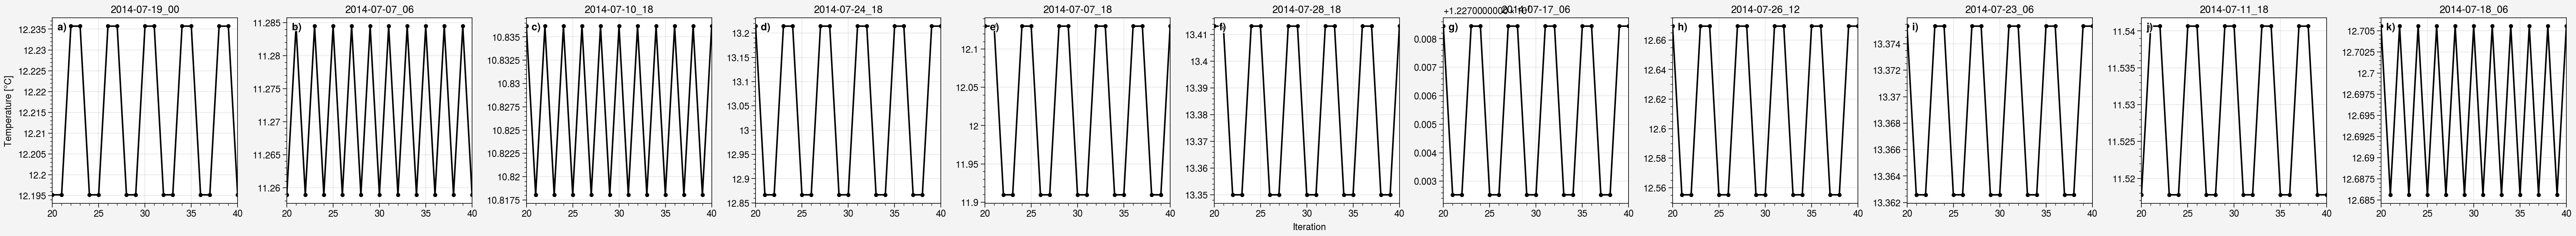

In [64]:
fig, axs = pplt.subplots(ncols=len(dates), sharey=1)

for index, date in enumerate(dates):
    ax = axs[index]
    data = oifs_progvars[index].t.isel(time=-1, nlev=-1) - 273.15
    data = data.sel(swr_iterate=range(20, 41))
    ax.plot(data, color="k", marker=".")
    ax.format(
        ylabel="Temperature [°C]",
        xlabel="Iteration",
        xlim=[20, 40],
        title=date,
    )

axs.format(
    abc="a)",
    abcloc='ul',
)
fig.savefig("nwp_oscillations_ece43.pdf")